<a href="https://colab.research.google.com/github/ckh13388/MachineLearning/blob/main/GAN/sceneary_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files, drive
files.upload()

In [2]:
from google.colab import files, drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download 'puneet6060/intel-image-classification'
! mkdir data
! unzip -q intel-image-classification.zip -d data
! rm intel-image-classification.zip

 96% 333M/346M [00:03<00:00, 111MB/s] 
100% 346M/346M [00:03<00:00, 114MB/s]


In [4]:
!ls

data  gdrive  kaggle.json  sample_data


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
batch_size, img_size = 32, (128,128)
latent_dim = 150
seed = 42

In [7]:
ds = keras.preprocessing.image_dataset_from_directory('./data/', label_mode=None, batch_size=batch_size, 
                                                      image_size=img_size, shuffle=True, seed=seed)
# Normalize the images to [-1, 1]
norm_ds = ds.map(lambda x: (x-127.5) / 127.5)

Found 24335 files belonging to 1 classes.


In [8]:
def upsampling(model, n):
  model.add(layers.Conv2DTranspose(n, 5, strides=2, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

def make_generator(latent_dim, n_filters, n_layers):
  model = keras.models.Sequential([layers.InputLayer(input_shape=(latent_dim,)),
                                   layers.Dense(4*4*512),
                                   layers.Reshape(target_shape=(4,4,512))],
                                   name='generator')
  for i in range(n_layers):
    upsampling(model, n_filters)
    n_filters /= 2
  
  model.add(layers.Conv2DTranspose(3, 5, strides=1, padding='same', activation='tanh'))

  return model

def downsampling(model, n):
  model.add(layers.Conv2D(n, 5, strides=2, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

def make_discriminator(n_filters, n_layers):
  model = keras.models.Sequential(name='discriminator')
  model.add(layers.InputLayer(input_shape=(img_size + (3,))))

  for i in range(n_layers):
    downsampling(model, n_filters)
    n_filters *= 2

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1, activation="sigmoid"))

  return model

In [9]:
generator = make_generator(latent_dim, 256, 5)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              1236992   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       819328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       51

In [10]:
discriminator = make_discriminator(16, 6)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        1216      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        12832     
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)      

In [11]:
class dcgan(keras.models.Sequential):
  def __init__(self, modelG, modelD, latent_dim=128, **kwargs):
    super().__init__()
    self.modelG = modelG
    self.modelD = modelD
    self.latent_dim = latent_dim
  
  def compile(self, optimizerG, optimizerD, lossfnG, lossfnD):
    super().compile()
    self.optimizerG = optimizerG
    self.optimizerD = optimizerD
    self.lossfnG = lossfnG
    self.lossfnD = lossfnD
    self.loss_metricG = keras.metrics.Mean()
    self.loss_metricD = keras.metrics.Mean()

  @property
  def metrics(self):
      return [self.loss_metricG, self.loss_metricD]


  def train_step(self, data):
    size = tf.shape(data)[0]
    rmd_latent_vects = tf.random.normal(shape=(size, self.latent_dim))

    #train 
    with tf.GradientTape() as tapeG, tf.GradientTape() as tapeD:
      
      # create fake items
      fake = self.modelG(rmd_latent_vects, training=True)

      # predicts
      real_output = self.modelD(data, training=True)
      fake_output = self.modelD(fake, training=True)
      
      # compute losses 
      lossD = lossfnD(real_output, fake_output)
      lossG = lossfnG(fake_output)

    # apply backward path and update weights
    gradsD = tapeD.gradient(lossD, self.modelD.trainable_weights)
    self.optimizerD.apply_gradients(zip(gradsD, self.modelD.trainable_weights))
    
    gradsG = tapeG.gradient(lossG, self.modelG.trainable_weights)
    self.optimizerG.apply_gradients(zip(gradsG, self.modelG.trainable_weights))

    self.loss_metricG.update_state(lossG)
    self.loss_metricD.update_state(lossD)

    return {'generator_loss': self.loss_metricG.result(),
            'discriminator_loss': self.loss_metricD.result()}

  def plotimg(self):
    images = self.modelG(tf.random.normal(shape=(8, self.latent_dim)), training=False)

    plt.figure(figsize=(9,9))

    for i, image in enumerate(images):
      plt.subplot(1,8,i+1)
      plt.imshow(image*0.5 + 0.5)
      plt.axis('off')

    plt.show()

  def get_config(self):
    base_config = super().get_config()
    config = {'modelG': self.modelG, 'modelD': self.modelD, 'latent_dim': self.latent_dim}
    return dict(list(base_config.items()) + list(config.items()))


class monitor(keras.callbacks.Callback):
  
  def on_epoch_end(self, epoch, logs=None):
    self.model.plotimg()
    if (epoch+1) % 5 == 0:
      checkpoint.save(file_prefix=ckpt_dir)
      self.model.modelG.save('gdrive/MyDrive/gan_checkpoint/generator{}.h5'.format(epoch+1))
      self.model.modelD.save('gdrive/MyDrive/gan_checkpoint/discriminator{}.h5'.format(epoch+1))

In [12]:
gan = dcgan(generator, discriminator, latent_dim)

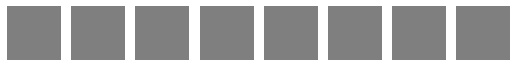

In [13]:
gan.plotimg()

In [14]:
# define loss functions
def lossfnG(fake):
  loss = keras.losses.BinaryCrossentropy()
  return loss(tf.ones_like(fake), fake)

def lossfnD(real, fake):
  loss = keras.losses.BinaryCrossentropy()
  real_loss = loss(tf.ones_like(real), real)
  fake_loss = loss(tf.zeros_like(fake), fake)
  return real_loss + fake_loss

optimizerG = keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.5) 
optimizerD = keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.5)

In [16]:
gan.compile(optimizerG, optimizerD, lossfnG, lossfnD)

In [17]:
# set checkpoint
ckpt_dir = 'gdrive/MyDrive/gan_checkpoint/'
checkpoint = tf.train.Checkpoint(generator_optimizer=gan.optimizerG,
                                 discriminator_optimizer=gan.optimizerD,
                                 generator=gan.modelG,
                                 discriminator=gan.modelD)
ckpt_manager = tf.train.CheckpointManager(checkpoint, ckpt_dir, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  checkpoint.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [18]:
init_epoch = int(checkpoint.save_counter * 5)
epoch = init_epoch + 100

Epoch 1/100
761/761 [==============================] - 71s 88ms/step - generator_loss: 2.7066 - discriminator_loss: 0.8830


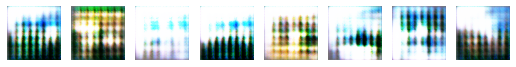

Epoch 2/100
761/761 [==============================] - 70s 92ms/step - generator_loss: 1.5464 - discriminator_loss: 0.9533


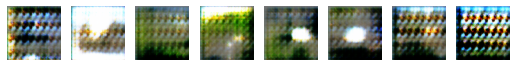

Epoch 3/100
761/761 [==============================] - 71s 93ms/step - generator_loss: 1.5374 - discriminator_loss: 0.9368


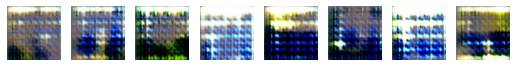

Epoch 4/100
761/761 [==============================] - 71s 93ms/step - generator_loss: 1.3517 - discriminator_loss: 1.0404


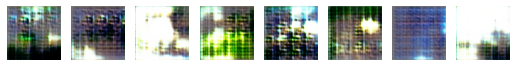

Epoch 5/100
761/761 [==============================] - 72s 94ms/step - generator_loss: 1.4212 - discriminator_loss: 1.0107


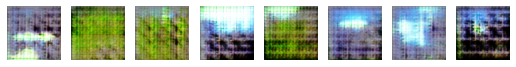

Epoch 6/100
761/761 [==============================] - 72s 94ms/step - generator_loss: 1.4532 - discriminator_loss: 1.0036


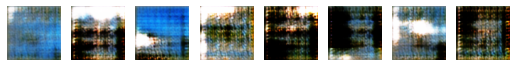

Epoch 7/100
761/761 [==============================] - 72s 94ms/step - generator_loss: 1.7602 - discriminator_loss: 1.0030


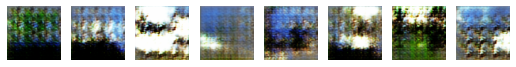

Epoch 8/100
761/761 [==============================] - 72s 94ms/step - generator_loss: 1.2248 - discriminator_loss: 1.0529


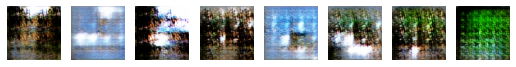

Epoch 9/100
761/761 [==============================] - 71s 93ms/step - generator_loss: 1.2797 - discriminator_loss: 1.0477


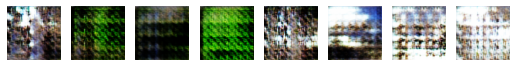

Epoch 10/100
761/761 [==============================] - 72s 94ms/step - generator_loss: 1.1353 - discriminator_loss: 1.1310


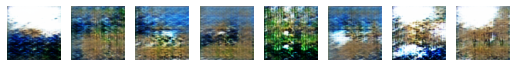

Epoch 11/100
761/761 [==============================] - 71s 93ms/step - generator_loss: 1.1423 - discriminator_loss: 1.1485


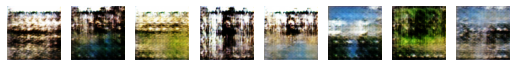

Epoch 12/100
761/761 [==============================] - 72s 94ms/step - generator_loss: 1.0690 - discriminator_loss: 1.1363


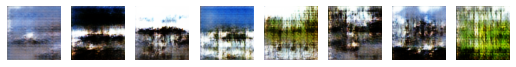

Epoch 13/100
761/761 [==============================] - 72s 94ms/step - generator_loss: 1.1069 - discriminator_loss: 1.1564


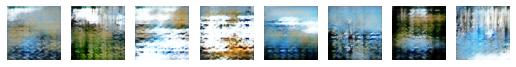

Epoch 14/100
761/761 [==============================] - 72s 94ms/step - generator_loss: 1.2243 - discriminator_loss: 1.0701


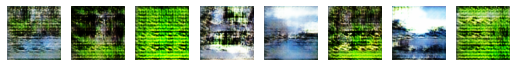

Epoch 15/100
761/761 [==============================] - 71s 94ms/step - generator_loss: 1.1606 - discriminator_loss: 1.0805


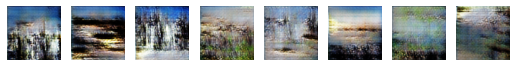

Epoch 16/100
761/761 [==============================] - 72s 94ms/step - generator_loss: 1.3731 - discriminator_loss: 0.9986


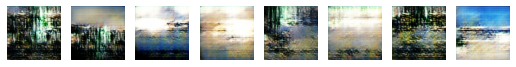

Epoch 17/100
761/761 [==============================] - 72s 94ms/step - generator_loss: 1.5248 - discriminator_loss: 0.9769


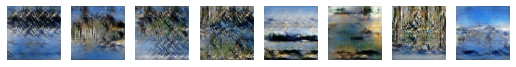

Epoch 18/100
761/761 [==============================] - 72s 95ms/step - generator_loss: 1.9759 - discriminator_loss: 0.8016


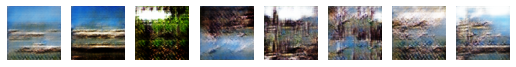

Epoch 19/100
761/761 [==============================] - 72s 94ms/step - generator_loss: 2.0331 - discriminator_loss: 0.7702


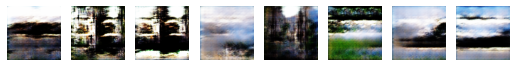

Epoch 20/100
761/761 [==============================] - 72s 94ms/step - generator_loss: 2.4940 - discriminator_loss: 0.6612


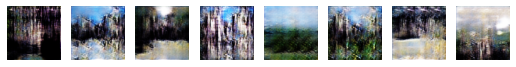

Epoch 21/100
761/761 [==============================] - 72s 94ms/step - generator_loss: 2.6306 - discriminator_loss: 0.6234


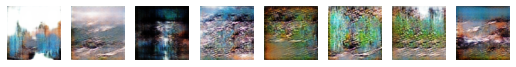

Epoch 22/100
761/761 [==============================] - 72s 94ms/step - generator_loss: 2.8888 - discriminator_loss: 0.5945


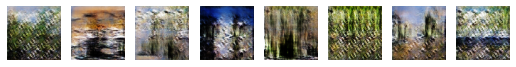

Epoch 23/100
761/761 [==============================] - 72s 94ms/step - generator_loss: 3.1534 - discriminator_loss: 0.5448


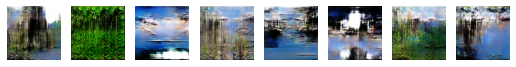

Epoch 24/100
761/761 [==============================] - 72s 94ms/step - generator_loss: 3.1733 - discriminator_loss: 0.5608


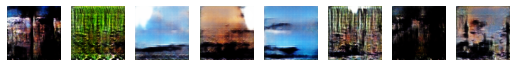

Epoch 25/100
761/761 [==============================] - 72s 94ms/step - generator_loss: 3.3672 - discriminator_loss: 0.5078


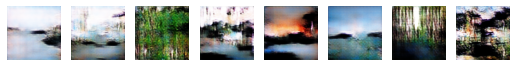

Epoch 26/100
761/761 [==============================] - 72s 94ms/step - generator_loss: 3.4710 - discriminator_loss: 0.4875


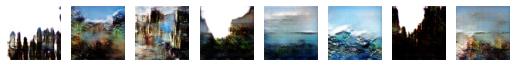

Epoch 27/100
761/761 [==============================] - 72s 94ms/step - generator_loss: 3.8812 - discriminator_loss: 0.4019


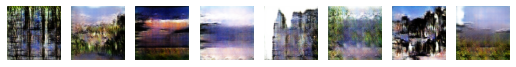

Epoch 28/100
761/761 [==============================] - 72s 95ms/step - generator_loss: 3.9924 - discriminator_loss: 0.4362


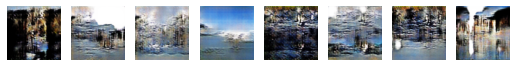

Epoch 29/100
761/761 [==============================] - 72s 95ms/step - generator_loss: 4.1008 - discriminator_loss: 0.3898


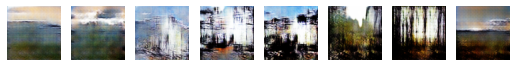

Epoch 30/100
761/761 [==============================] - 73s 95ms/step - generator_loss: 4.0193 - discriminator_loss: 0.4294


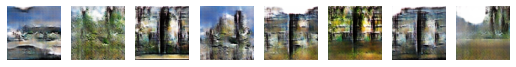

Epoch 31/100
761/761 [==============================] - 72s 95ms/step - generator_loss: 4.1164 - discriminator_loss: 0.3803


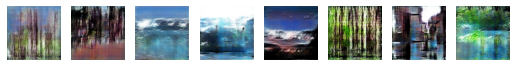

Epoch 32/100
761/761 [==============================] - 73s 95ms/step - generator_loss: 4.1856 - discriminator_loss: 0.4193


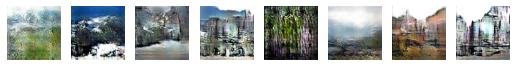

Epoch 33/100
761/761 [==============================] - 73s 95ms/step - generator_loss: 4.1025 - discriminator_loss: 0.3696


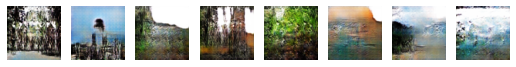

Epoch 34/100
761/761 [==============================] - 73s 95ms/step - generator_loss: 4.2117 - discriminator_loss: 0.4021


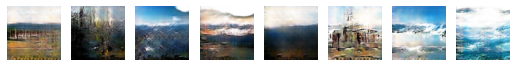

Epoch 35/100
761/761 [==============================] - 73s 95ms/step - generator_loss: 4.1913 - discriminator_loss: 0.3532


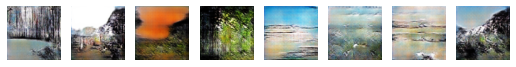

Epoch 36/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 4.0322 - discriminator_loss: 0.3991


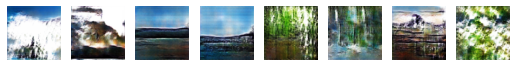

Epoch 37/100
761/761 [==============================] - 73s 95ms/step - generator_loss: 4.3687 - discriminator_loss: 0.4010


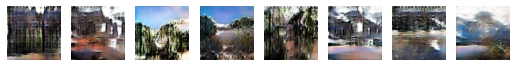

Epoch 38/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 4.1176 - discriminator_loss: 0.3654


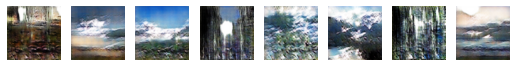

Epoch 39/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 4.5184 - discriminator_loss: 0.3480


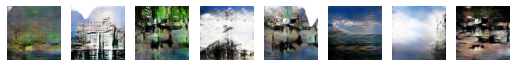

Epoch 40/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 4.4270 - discriminator_loss: 0.3661


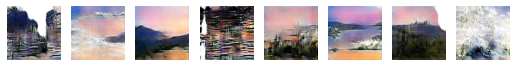

Epoch 41/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 4.6092 - discriminator_loss: 0.3694


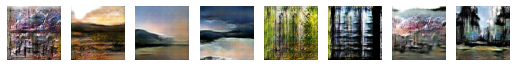

Epoch 42/100
761/761 [==============================] - 73s 95ms/step - generator_loss: 4.3489 - discriminator_loss: 0.3457


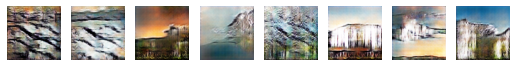

Epoch 43/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 4.4829 - discriminator_loss: 0.3662


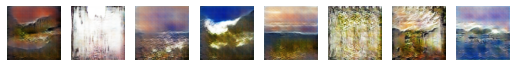

Epoch 44/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 4.6301 - discriminator_loss: 0.3210


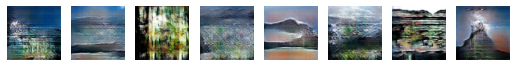

Epoch 45/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 4.4830 - discriminator_loss: 0.3387


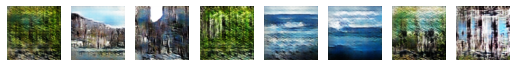

Epoch 46/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 4.4607 - discriminator_loss: 0.3537


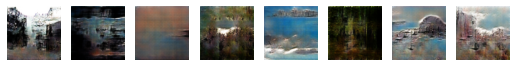

Epoch 47/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 4.6324 - discriminator_loss: 0.3122


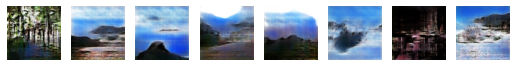

Epoch 48/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 4.4510 - discriminator_loss: 0.3320


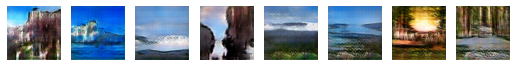

Epoch 49/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 4.6200 - discriminator_loss: 0.3100


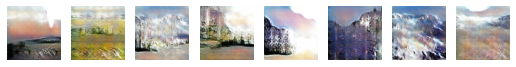

Epoch 50/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 4.5718 - discriminator_loss: 0.3120


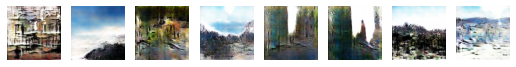

Epoch 51/100
761/761 [==============================] - 73s 95ms/step - generator_loss: 4.7087 - discriminator_loss: 0.3014


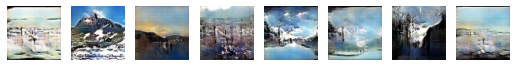

Epoch 52/100
761/761 [==============================] - 73s 95ms/step - generator_loss: 4.6435 - discriminator_loss: 0.3138


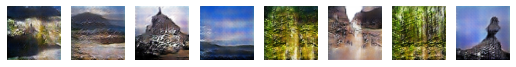

Epoch 53/100
761/761 [==============================] - 73s 95ms/step - generator_loss: 4.6566 - discriminator_loss: 0.2894


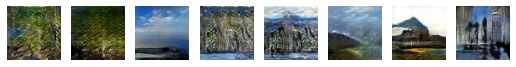

Epoch 54/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 4.6063 - discriminator_loss: 0.3058


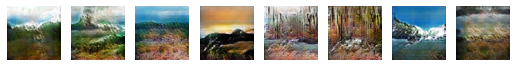

Epoch 55/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 4.5812 - discriminator_loss: 0.3498


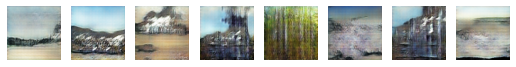

Epoch 56/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 5.0549 - discriminator_loss: 0.3052


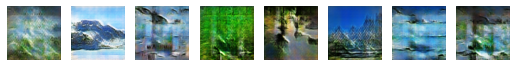

Epoch 57/100
761/761 [==============================] - 72s 95ms/step - generator_loss: 4.6896 - discriminator_loss: 0.3022


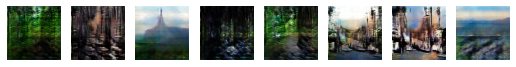

Epoch 58/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 4.8665 - discriminator_loss: 0.3118


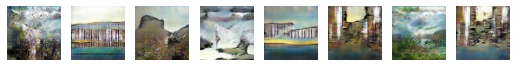

Epoch 59/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 4.7698 - discriminator_loss: 0.3365


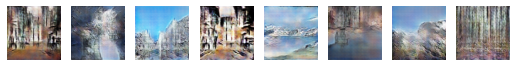

Epoch 60/100
761/761 [==============================] - 73s 95ms/step - generator_loss: 4.6734 - discriminator_loss: 0.3152


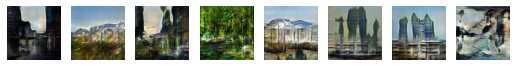

Epoch 61/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 4.6993 - discriminator_loss: 0.3232


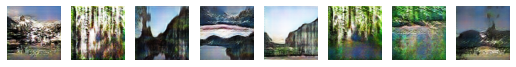

Epoch 62/100
761/761 [==============================] - 72s 95ms/step - generator_loss: 4.9521 - discriminator_loss: 0.2817


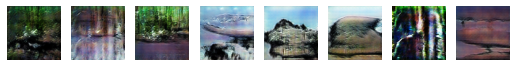

Epoch 63/100
761/761 [==============================] - 73s 95ms/step - generator_loss: 5.1934 - discriminator_loss: 0.2819


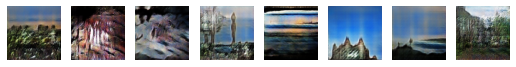

Epoch 64/100
761/761 [==============================] - 73s 95ms/step - generator_loss: 5.2230 - discriminator_loss: 0.3097


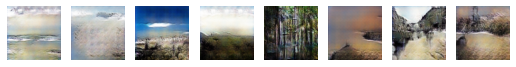

Epoch 65/100
761/761 [==============================] - 72s 95ms/step - generator_loss: 5.3595 - discriminator_loss: 0.2904


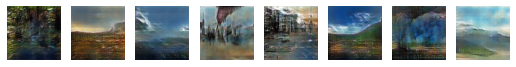

Epoch 66/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 5.7930 - discriminator_loss: 0.2622


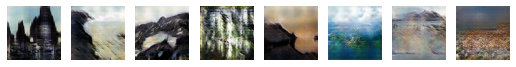

Epoch 67/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 5.6749 - discriminator_loss: 0.2630


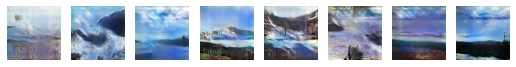

Epoch 68/100
761/761 [==============================] - 72s 95ms/step - generator_loss: 5.6703 - discriminator_loss: 0.2627


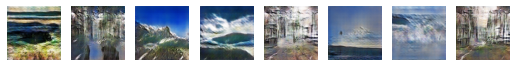

Epoch 69/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 5.4747 - discriminator_loss: 0.2759


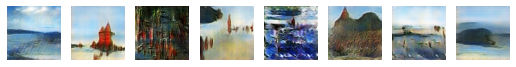

Epoch 70/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 5.4592 - discriminator_loss: 0.2738


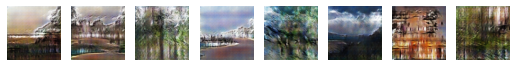

Epoch 71/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 5.4609 - discriminator_loss: 0.2703


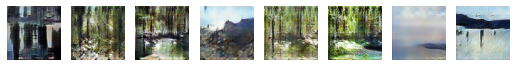

Epoch 72/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 5.3043 - discriminator_loss: 0.2752


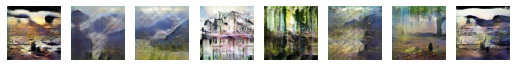

Epoch 73/100
761/761 [==============================] - 74s 97ms/step - generator_loss: 5.2541 - discriminator_loss: 0.2582


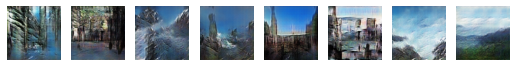

Epoch 74/100
761/761 [==============================] - 74s 97ms/step - generator_loss: 5.2911 - discriminator_loss: 0.2926


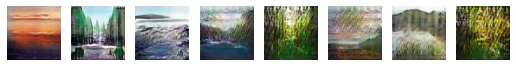

Epoch 75/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 5.4444 - discriminator_loss: 0.2425


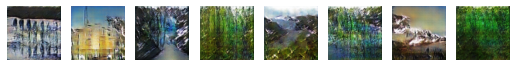

Epoch 76/100
761/761 [==============================] - 74s 96ms/step - generator_loss: 5.5508 - discriminator_loss: 0.2561


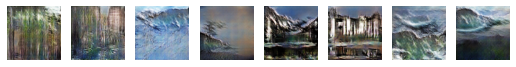

Epoch 77/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 5.9681 - discriminator_loss: 0.2604


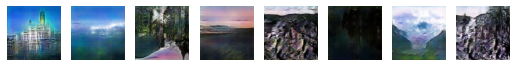

Epoch 78/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 5.5339 - discriminator_loss: 0.2613


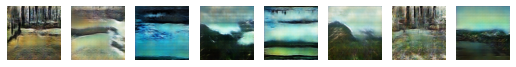

Epoch 79/100
761/761 [==============================] - 74s 97ms/step - generator_loss: 5.3551 - discriminator_loss: 0.3094


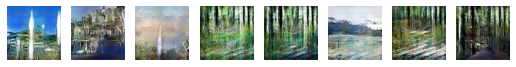

Epoch 80/100
761/761 [==============================] - 73s 96ms/step - generator_loss: 5.6023 - discriminator_loss: 0.2123


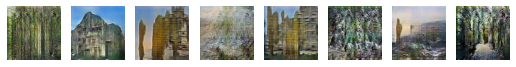

Epoch 81/100
761/761 [==============================] - 74s 97ms/step - generator_loss: 4.9787 - discriminator_loss: 0.2732


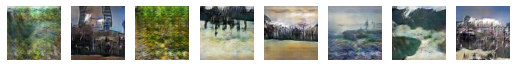

Epoch 82/100
761/761 [==============================] - 74s 97ms/step - generator_loss: 5.2770 - discriminator_loss: 0.2517


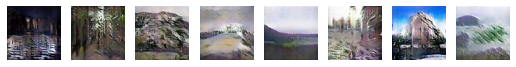

Epoch 83/100
761/761 [==============================] - 74s 97ms/step - generator_loss: 5.0811 - discriminator_loss: 0.2265


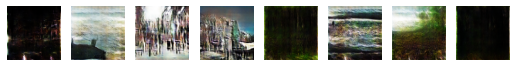

Epoch 84/100
761/761 [==============================] - 74s 97ms/step - generator_loss: 5.1298 - discriminator_loss: 0.2495


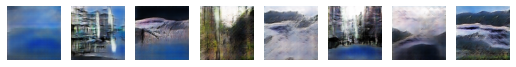

Epoch 85/100
761/761 [==============================] - 74s 97ms/step - generator_loss: 5.4773 - discriminator_loss: 0.2576


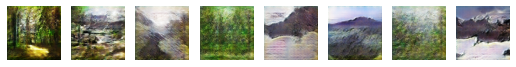

Epoch 86/100
761/761 [==============================] - 74s 97ms/step - generator_loss: 5.5192 - discriminator_loss: 0.2304


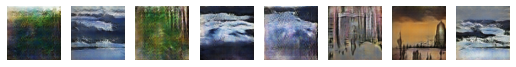

Epoch 87/100
761/761 [==============================] - 74s 98ms/step - generator_loss: 5.5652 - discriminator_loss: 0.2502


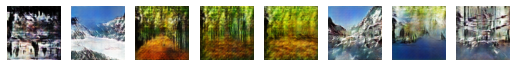

Epoch 88/100
761/761 [==============================] - 74s 97ms/step - generator_loss: 5.2113 - discriminator_loss: 0.2583


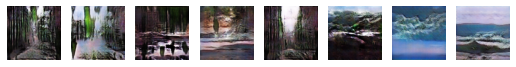

Epoch 89/100
761/761 [==============================] - 74s 97ms/step - generator_loss: 5.5885 - discriminator_loss: 0.2239


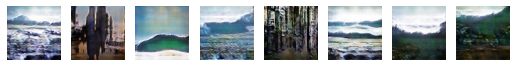

Epoch 90/100
761/761 [==============================] - 74s 98ms/step - generator_loss: 5.6686 - discriminator_loss: 0.2187


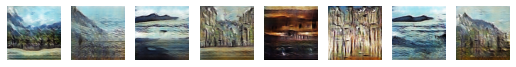

Epoch 91/100
761/761 [==============================] - 75s 98ms/step - generator_loss: 6.0430 - discriminator_loss: 0.2154


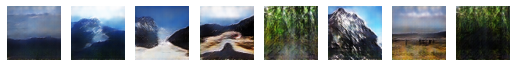

Epoch 92/100
761/761 [==============================] - 74s 97ms/step - generator_loss: 5.8217 - discriminator_loss: 0.2165


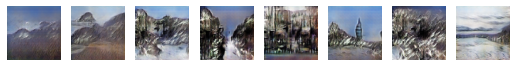

Epoch 93/100
761/761 [==============================] - 74s 97ms/step - generator_loss: 5.5508 - discriminator_loss: 0.2341


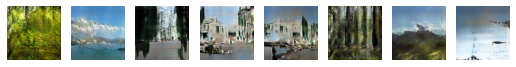

Epoch 94/100
761/761 [==============================] - 74s 97ms/step - generator_loss: 5.8744 - discriminator_loss: 0.2035


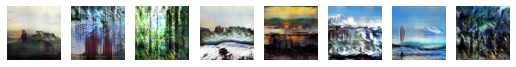

Epoch 95/100
761/761 [==============================] - 74s 97ms/step - generator_loss: 6.1319 - discriminator_loss: 0.2060


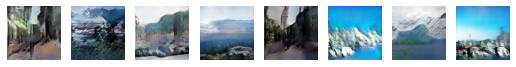

Epoch 96/100
761/761 [==============================] - 75s 98ms/step - generator_loss: 6.3203 - discriminator_loss: 0.2126


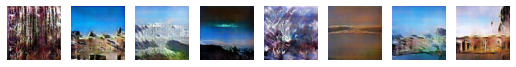

Epoch 97/100
761/761 [==============================] - 75s 98ms/step - generator_loss: 5.7978 - discriminator_loss: 0.2122


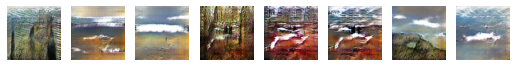

Epoch 98/100
761/761 [==============================] - 75s 99ms/step - generator_loss: 5.8637 - discriminator_loss: 0.2478


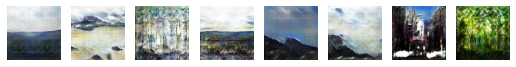

Epoch 99/100
761/761 [==============================] - 74s 98ms/step - generator_loss: 5.7834 - discriminator_loss: 0.2120


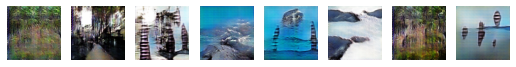

Epoch 100/100
761/761 [==============================] - 75s 99ms/step - generator_loss: 5.6365 - discriminator_loss: 0.2421


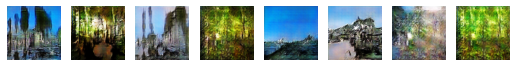

In [20]:
h = gan.fit(x=norm_ds, epochs=epoch, initial_epoch=init_epoch, callbacks=[monitor()])

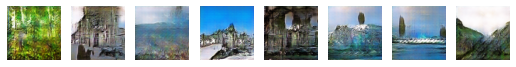

In [25]:
gan.plotimg()

In [24]:
gan_hist = pd.DataFrame(h.history)

Text(0.5, 1.0, 'Discriminator_loss')

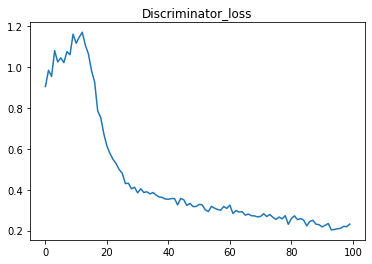

In [53]:
gan_hist['discriminator_loss'].plot()
plt.title('Discriminator_loss')

Text(0.5, 1.0, 'Generator_loss')

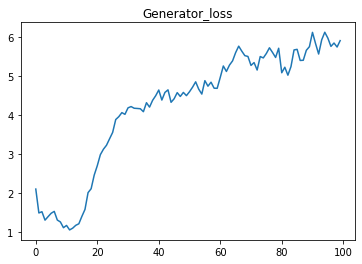

In [54]:
gan_hist['generator_loss'].plot()
plt.title('Generator_loss')

In [49]:
rmd_latent_vects = tf.random.normal(shape=(8, latent_dim))

In [50]:
generated = gan.modelG(rmd_latent_vects)
pred = gan.modelD(generated).numpy()

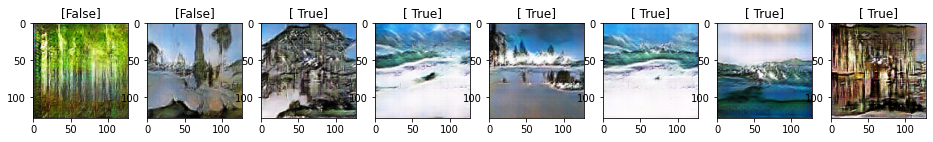

In [51]:
plt.figure(figsize=(16, 9))
for i in range(generated.shape[0]):
  ax = plt.subplot(1, generated.shape[0], i+1)
  plt.title(str(pred[i]>0.5))
  plt.imshow(generated[i]*0.5+0.5)

The generator is making similar images.